In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report,accuracy_score,f1_score


from keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM,Conv2D, MaxPooling2D, Flatten, Input
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical ,load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop,SGD
from tensorflow.keras.models import load_model
from keras import callbacks
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

from tqdm.notebook import tqdm
import random
import os

HANDLE DATA

In [4]:
dir_train = r'E:\College\Engineering\6\A.I\Face\crop_part1'

image_paths = []
age_labels = []
gender_labels = []
shape_labels = []

for filename in tqdm(os.listdir(dir_train)):
    image_path = os.path.join(dir_train, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    shape = int(temp[2])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    shape_labels.append(shape)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['shape'] = image_paths, age_labels, gender_labels, shape_labels
df.head()

,image,age,gender,shape
0,E:\College\Engineering\6\A.I\Face\crop_part1\1...,100,1,0
1,E:\College\Engineering\6\A.I\Face\crop_part1\1...,100,1,2
2,E:\College\Engineering\6\A.I\Face\crop_part1\1...,101,1,2
3,E:\College\Engineering\6\A.I\Face\crop_part1\1...,10,0,0
4,E:\College\Engineering\6\A.I\Face\crop_part1\1...,10,0,0


In [42]:
# map labels for gender
gender_dict = {0:'Female', 1:'Male'}

# map labels for shape
shape_dict = {0:'Diamond', 1:'Round',2:'Oval',3:'Rectangle',4:'Heart'}

d:\Python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

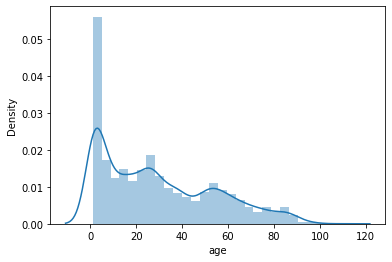

In [7]:
sns.distplot(df['age'])

d:\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shape', ylabel='count'>

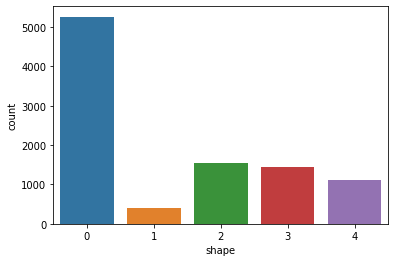

In [8]:
sns.countplot(df['shape'])

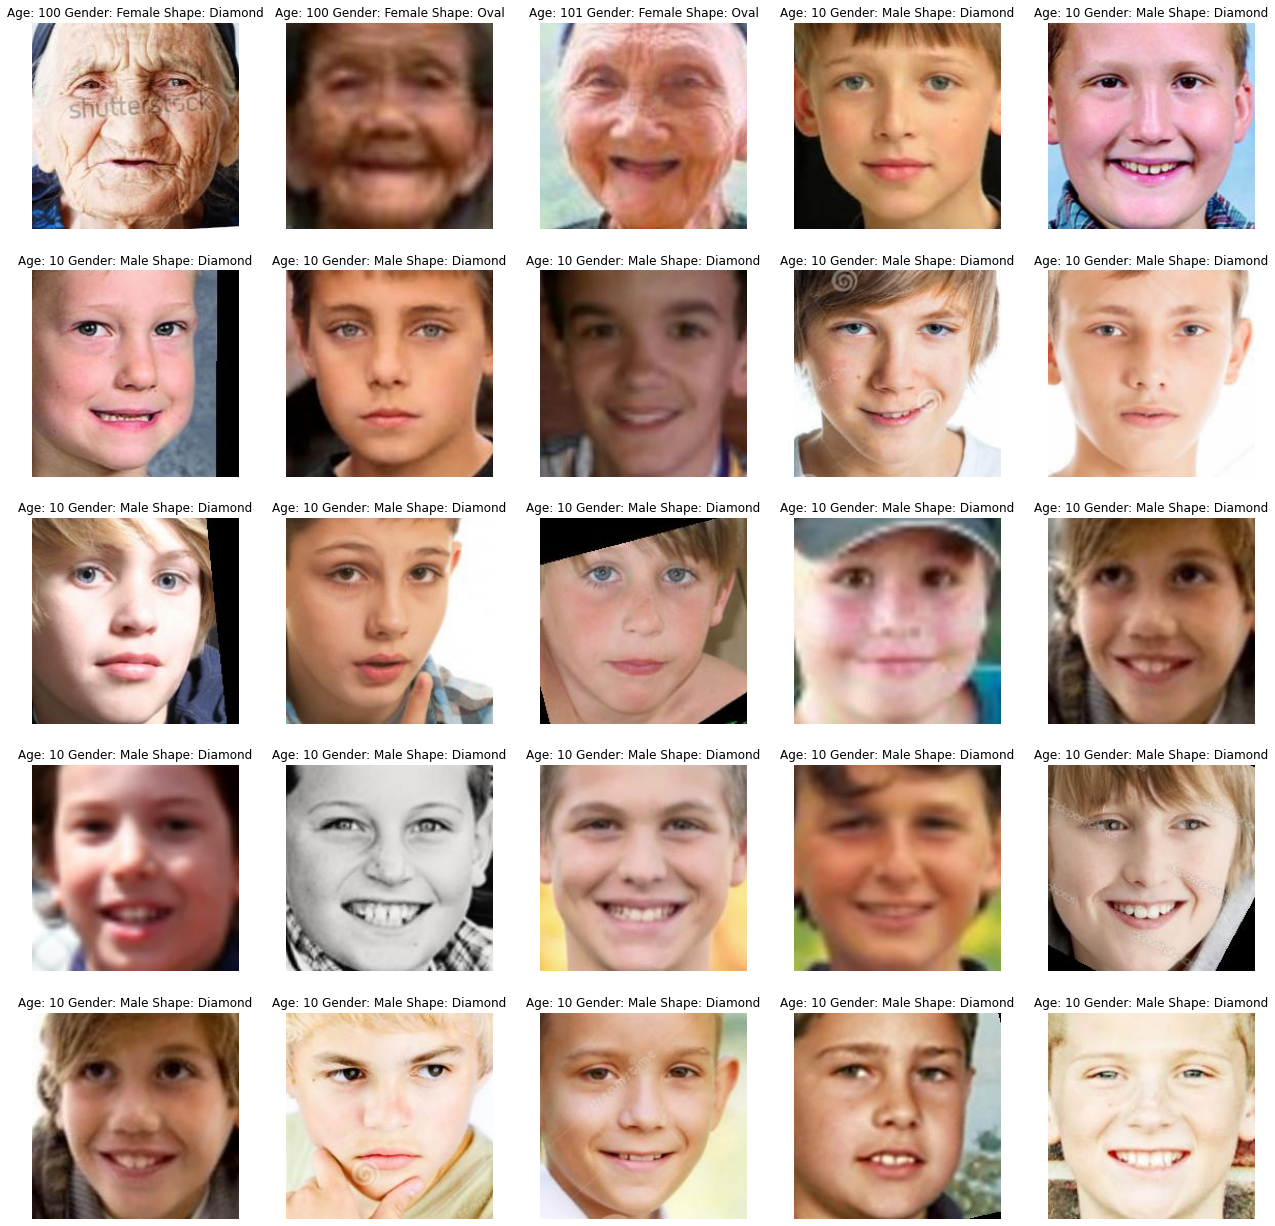

In [9]:
plt.figure(figsize=(22, 22))
files = df.iloc[0:25]

for index, file, age, gender, shape in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]} Shape: {shape_dict[shape]}")
    plt.axis('off')

CREATE MODEL

In [15]:
input_shape = (150,150, 1)
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)
dense_3 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)
dropout_3 = Dropout(0.3) (dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)
output_3 = Dense(1, activation='relu', name='shape_out') (dropout_3)

model = Model(inputs=[inputs], outputs=[output_1, output_2,output_3])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

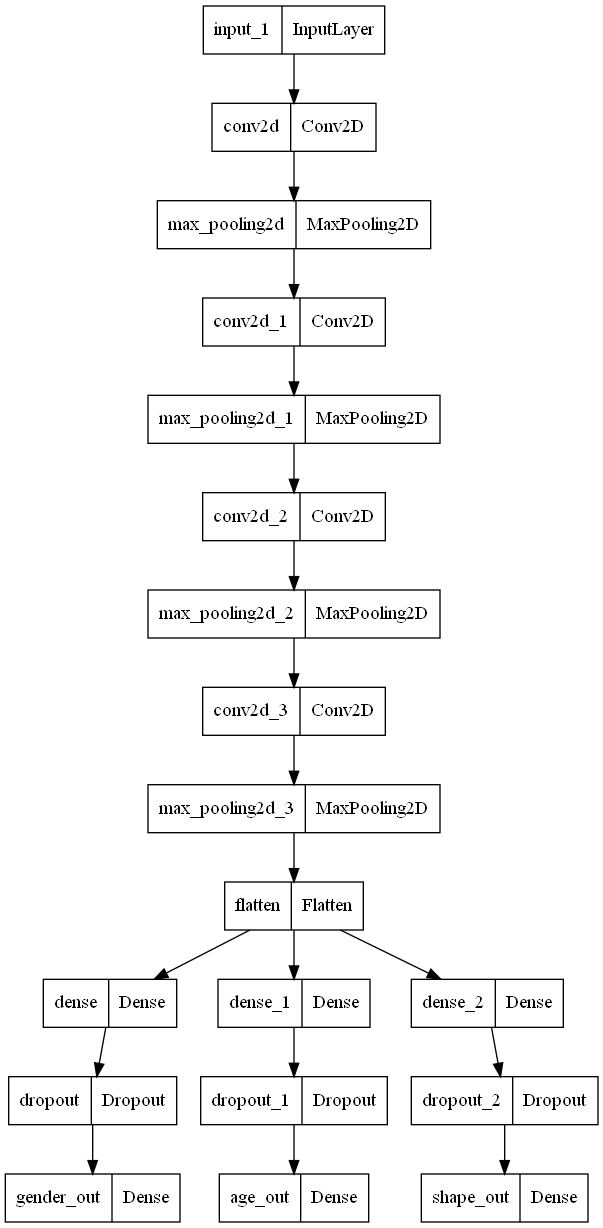

In [11]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [12]:
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((150, 150), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # Gray change
    features = features.reshape(len(features), 150, 150, 1)
    return features

In [13]:
X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_shape = np.array(df['shape'])

  0%|          | 0/9780 [00:00<?, ?it/s]

d:\Python\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\Admin\AppData\Local\Temp\ipykernel_10960\1771442382.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((150, 150), Image.ANTIALIAS)


In [16]:
# train model
history = model.fit(x=X, y=[y_gender, y_age, y_shape], batch_size=32, epochs=30, validation_split=0.2)

245/245 [==============================] - 7471s 30s/step - loss: 5.6264 - gender_out_loss: 0.3171 - age_out_loss: 5.3093 - gender_out_accuracy: 0.8429 - age_out_accuracy: 0.0114 - shape_out_accuracy: 0.3928 - val_loss: 19.1470 - val_gender_out_loss: 0.5321 - val_age_out_loss: 18.6150 - val_gender_out_accuracy: 0.7791 - val_age_out_accuracy: 0.0000e+00 - val_shape_out_accuracy: 0.6723
Epoch 15/30
245/245 [==============================] - 8061s 33s/step - loss: 5.3506 - gender_out_loss: 0.3036 - age_out_loss: 5.0470 - gender_out_accuracy: 0.8501 - age_out_accuracy: 0.0120 - shape_out_accuracy: 0.3903 - val_loss: 21.5085 - val_gender_out_loss: 0.4606 - val_age_out_loss: 21.0479 - val_gender_out_accuracy: 0.8073 - val_age_out_accuracy: 0.0000e+00 - val_shape_out_accuracy: 0.6431
Epoch 16/30
245/245 [==============================] - 8266s 34s/step - loss: 5.2301 - gender_out_loss: 0.2920 - age_out_loss: 4.9382 - gender_out_accuracy: 0.8611 - age_out_accuracy: 0.0119 - shape_out_accuracy:

In [17]:
model.save('FaceShape_Gender_Age_30epochs.h5')

In [60]:
model = load_model('FaceShape_Gender_Age_30epochs.h5')

1/1 [==============================] - 1s 817ms/step
Predicted Gender: Male Predicted Age: 10 Predicted Shape: Round


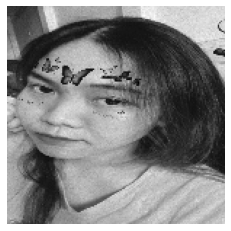

In [79]:
# predict from model
from PIL import Image
filename = r'test\trang (32).jpg'
img = load_img(filename,target_size = (150,150))
img = img.convert('L')
img = img_to_array(img)
img =  img.reshape(1,150,150,1)
#img = img.astype('float32')
img = img/255

pred = model.predict(img)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_shape = shape_dict[round(pred[0][0][0])]
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age, "Predicted Shape:", pred_shape )
plt.axis('off')
plt.imshow(img.reshape(150, 150), cmap='gray');
